# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第10节 比特币, 莱特币的回测</b></font>
</center>

-----------------

作者: 阿布

[abu量化系统github地址(欢迎+star，你的支持是我更新的动力！)](https://github.com/bbfamily/abu) 

[本节ipython notebook:](https://github.com/bbfamily/abu/abupy_lecture)

上一节讲解的是港股市场的回测，以及使用AbuTLine.show_least_valid_poly优化策略，提高系统的稳定性，本节主要示例比特币与莱特币的走势分析与回测。

首先导入需要使用的abupy中的模块： 

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)

import os
import sys
sys.path.append(os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak, ABuProgress
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuSymbolPd, tl, get_price, ABuMarketDrawing, ABuKLUtil

### 1. 比特币, 莱特币的走势数据分析

abupy内置沙盒数据中：

* 比特币的数据是从2013-09-01至2017-07-26
* 莱特币的数据是从2014-03-19至2017-07-26

很多人说做币类市场更容易，因为整个市场就两个能做的票，比特币，莱特币，但是真的是这样吗？

我《在量化交易之路》中反复强调：量化策略失败结果的人工分析，是对策略结果影响非常大的一个环节，但是在失败结果分析前，对交易目标的历史数据进行
分析也是对策略结果影响非常大的一个环节，通过观察交易目标，分析价格走势，趋势的分布，策略的适配度，以致生成定制针对交易目标的特定策略都是在这个环节中涉及的，由于本文只是abupy使用文档，所以不涉及与交易牵扯过深的知识，本节只示例一些简单的数据分析以及可视化分析技巧。

首先使用ABuSymbolPd.make_kl_df接口将btc和ltc沙盒中的数据请求到对象btc，ltc中：

备注：下面使用btc.tail(7)可以看到交易日是连续的，因为比特币和莱特币一年365天都可交易

In [3]:
# btc是比特币symbol代号
btc = ABuSymbolPd.make_kl_df('btc', start='2013-09-01', end='2017-07-26')
# btc是莱特币symbol代号
ltc = ABuSymbolPd.make_kl_df('ltc', start='2014-03-19', end='2017-07-26')
btc.tail(7)

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14
2017-07-20,16070.00,17519.83,17840.01,15666.00,17327,20170720,16070.00,3,9.022,1418,1617.3395,1749.5687
2017-07-21,17520.00,18330.00,19779.72,17450.13,22751,20170721,17519.83,4,4.624,1419,1807.5559,2010.9222
2017-07-22,18342.00,18657.00,19388.00,17908.00,16133,20170722,18330.00,5,1.784,1420,1813.0663,1991.8886
2017-07-23,18635.01,18362.10,19000.00,17380.00,13963,20170723,18657.00,6,-1.581,1421,1795.5148,1942.3034
2017-07-24,18362.18,18379.62,18668.00,17718.22,8248,20170724,18362.10,0,0.095,1422,1718.6298,1809.9670
2017-07-25,18379.80,17763.31,18898.00,17416.00,14956,20170725,18379.62,1,-3.353,1423,1697.1180,1766.2380
2017-07-26,17751.34,17200.00,17910.00,17000.00,4789,20170726,17763.31,2,-3.171,1424,1668.2546,1714.6890


下面通过ABuMarketDrawing.plot_simple_two_stock缩放到一个级别上进行走势对比，走势基本相似，ltc的启动要慢btc:

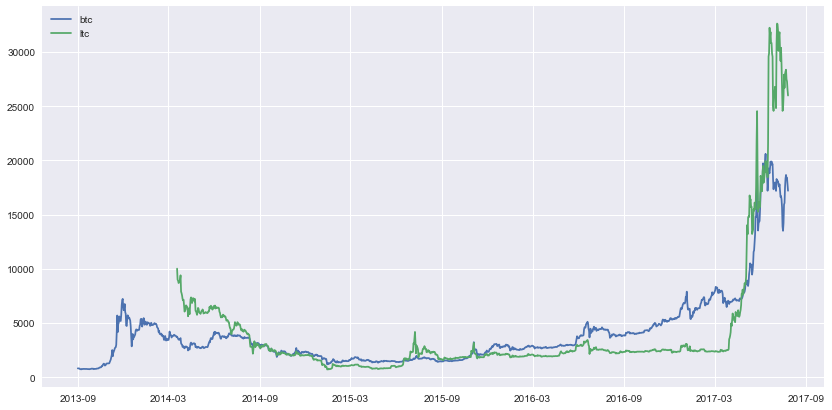

In [4]:
ABuMarketDrawing.plot_simple_two_stock({'btc': btc, 'ltc': ltc})

由于最近一年的走势和之前差别很大，所以单独切割出btc365, ltc365：

In [5]:
btc365 = btc[-365:]
ltc365 = ltc[-365:]

使用ABuKLUtil.date_week_wave统计交易日震荡幅度可以发现:

* 不管周几，每一天的比特币的震荡幅度不管是最近一年还是之前的走势都大概在每天5%上下
* 不管周几，每一天的莱特币的震荡幅度不管是最近一年还是之前的走势都大概在每天6%上下

In [6]:
ABuKLUtil.date_week_wave({'btc': btc, 'btc365':btc365, 'ltc':ltc, 'ltc365':ltc365})

,btcwave,btc365wave,ltcwave,ltc365wave
date_week,,,,
周一,5.0108,4.1032,5.7683,7.0101
周二,5.5610,4.5661,5.7854,6.1302
周三,5.4437,5.2015,6.1769,6.6820
周四,5.7275,5.2758,6.4790,7.1251
周五,5.3008,4.8591,7.0895,6.4484
周六,4.7875,4.7460,5.5900,6.1452
周日,4.6528,4.1319,5.7274,5.2575


下面统计周期内的上涨均值，下跌均值，以及数量，比值：

使用ABuKLUtil.p_change_stats可以发现:

* 比特币最近一年日涨跌幅度呈现稳定趋势：(up:2.615->2.264↓, down:-2.422->-2.135↓)
* 比特币最近一年的大趋势并不是每天的大幅拉升:日平均涨跌比1.080－>1.061↓，而是上涨的交易日远大于下跌的数量：上涨下跌数量比1.183－>1.411↑
* 莱特币最近一年日涨跌幅度呈现趋势上升：(up:3.275->3.645↑, down:-2.773->--2.421↓)
* 莱特币最近一年的大趋势是每天的大幅拉升:日平均涨跌比1.181－>1.5051↑，上涨的交易日远大于下跌的数量：上涨下跌数量比0.980－>1.151↑

In [7]:
ABuKLUtil.p_change_stats({'btc': btc, 'btc365': btc365, 'ltc': ltc, 'ltc365': ltc365})

btc日涨幅平均值2.615, 共770个交易日上涨走势
btc日跌幅平均值-2.422, 共651个交易日下跌走势
btc日平均涨跌比1.080, 上涨下跌数量比:1.183

btc365日涨幅平均值2.264, 共213个交易日上涨走势
btc365日跌幅平均值-2.135, 共151个交易日下跌走势
btc365日平均涨跌比1.061, 上涨下跌数量比:1.411

ltc日涨幅平均值3.275, 共596个交易日上涨走势
ltc日跌幅平均值-2.773, 共608个交易日下跌走势
ltc日平均涨跌比1.181, 上涨下跌数量比:0.980

ltc365日涨幅平均值3.645, 共191个交易日上涨走势
ltc365日跌幅平均值-2.421, 共166个交易日下跌走势
ltc365日平均涨跌比1.505, 上涨下跌数量比:1.151



如下ABuKLUtil.wave_change_rate所示比特币和莱特币日振幅涨跌幅比都在2.0以上, 具备日交易进行统计套利的条件：

备注：美股市场在1.8以上认为具有统计套利条件

In [8]:
ABuKLUtil.wave_change_rate({'btc': btc, 'ltc': ltc})

btc日振幅涨跌幅比：2.068436
ltc日振幅涨跌幅比：2.051736


使用ABuKLUtil.date_week_win查看每天的涨跌概率：

* 比特币周一周二周五上涨概率都接近60%，周六下跌概率大，且最近一年更是周一到周五每天都有接近60%上涨概率
* 莱特币上涨概率大于下跌概率最近一年，之前无明显套利模式

In [9]:
ABuKLUtil.date_week_win({'btc': btc, 'btc365': btc365, 'ltc': ltc, 'ltc365': ltc365})

,0,1,btcwin,0,1,btc365win,0,1,ltcwin,0,1,ltc365win
date_week,,,,,,,,,,,,
周一,86,118,0.5784,20,32,0.6154,84,91,0.5200,25,27,0.5192
周二,87,117,0.5735,19,33,0.6346,97,78,0.4457,31,21,0.4038
周三,96,108,0.5294,23,30,0.5660,84,92,0.5227,23,30,0.5660
周四,103,100,0.4926,20,32,0.6154,94,81,0.4629,21,31,0.5962
周五,76,127,0.6256,16,36,0.6923,80,95,0.5429,24,28,0.5385
周六,107,96,0.4729,31,21,0.4038,101,74,0.4229,26,26,0.5000
周日,100,104,0.5098,23,29,0.5577,90,85,0.4857,24,28,0.5385


使用ABuKLUtil.date_week_mean查看每天的带正负的涨跌mean：

* 莱特币最近一年平均都为正，且最大周三周四有1以上
* 比特币一直以来的数据都显示周一周二具有安全的套利空间

In [10]:
ABuKLUtil.date_week_mean({'btc': btc, 'btc365': btc365, 'ltc': ltc, 'ltc365': ltc365})

,btc_p_change,btc365_p_change,ltc_p_change,ltc365_p_change
date_week,,,,
周一,0.8582,0.5385,0.6145,0.9125
周二,0.6234,1.1676,0.2922,0.4649
周三,-0.0234,0.2435,0.4073,1.2143
周四,0.2149,0.9369,-0.2075,1.8159
周五,0.4270,0.1796,0.4723,0.2461
周六,-0.0676,-0.3809,-0.4483,0.4824
周日,0.1117,0.3871,0.3843,0.4972


下面使用ABuKLUtil.p_change_bcut_vc统计：

* 比特币和莱特币最频繁区间是(-3, 0], (0, 3]
* 比特币和莱特币在(-inf, -10]和(10, inf]的分布都有1%以上，莱特币(-inf, -10]：0.0228有2%以上，属于危险交易品种

In [11]:
ABuKLUtil.bcut_change_vc({'btc': btc, 'btc365': btc365, 'ltc': ltc, 'ltc365': ltc365})

,btc,btcrate,btc365,btc365rate,ltc,ltcrate,ltc365,ltc365rate
"(-10, -7]",19,0.0133,6,0.0164,29,0.0237,6,0.0164
"(-3, 0]",491,0.3446,116,0.3178,449,0.3662,130,0.3562
"(-7, -3]",116,0.0814,24,0.0658,124,0.1011,32,0.0877
"(-inf, -10]",29,0.0204,6,0.0164,28,0.0228,6,0.0164
"(0, 3]",555,0.3895,154,0.4219,421,0.3434,136,0.3726
"(10, inf]",28,0.0196,5,0.0137,45,0.0367,21,0.0575
"(3, 7]",149,0.1046,46,0.1260,103,0.0840,26,0.0712
"(7, 10]",38,0.0267,8,0.0219,27,0.0220,8,0.0219


上面使用bcut_change_vc无法知道(-inf, -10]和(10, inf]的正无穷与无穷的具体数值，使用qcut_change_vc：

* 比特币loss10: [-26.895, -3.284] , top10：(4.182, 38.786]
* 比特币最近一年风险下降：loss10: [-16.273, -2.783], top10：(3.948, 15.22]
* 莱特币loss10: [-28.48, -4.1]， top10：(4.405, 41.083]
* 莱特币最近一年继续呈现高风险loss10：[-22.823, -3.229] 高收益top10：(5.0606, 37.505]

In [12]:
ABuKLUtil.qcut_change_vc({'btc': btc, 'btc365': btc365, 'ltc': ltc, 'ltc365': ltc365})

,btcchange,btc365change,ltcchange,ltc365change
0,"[-26.895, -3.284]","[-16.273, -2.783]","[-28.48, -4.1]","[-22.823, -3.229]"
1,"(-3.284, -1.547]","(-2.783, -1.056]","(-4.1, -2.022]","(-3.229, -1.375]"
2,"(-1.547, -0.8]","(-1.056, -0.424]","(-2.022, -0.922]","(-1.375, -0.655]"
3,"(-0.8, -0.224]","(-0.424, -0.071]","(-0.922, -0.389]","(-0.655, -0.226]"
4,"(-0.224, 0.143]","(-0.071, 0.272]","(-0.389, 0]","(-0.226, 0.078]"
5,"(0.143, 0.568]","(0.272, 0.698]","(0, 0.413]","(0.078, 0.453]"
6,"(0.568, 1.108]","(0.698, 1.316]","(0.413, 0.977]","(0.453, 0.913]"
7,"(1.108, 2.171]","(1.316, 2.334]","(0.977, 1.889]","(0.913, 1.957]"
8,"(2.171, 4.182]","(2.334, 3.948]","(1.889, 4.405]","(1.957, 5.0606]"
9,"(4.182, 38.786]","(3.948, 15.22]","(4.405, 41.083]","(5.0606, 37.505]"


上面通过数据的转换分析对比特币，莱特币进行了分析，下面通过可视化对比特币，莱特币进行分析

### 2 比特币, 莱特币的走势可视化分析

下面封装一个函数使用AbuTLine中的可视化接口分析数据：

备注: 关于AbuTLine中的具体实现以及接口的功能作用请阅读源代码AbuTLine

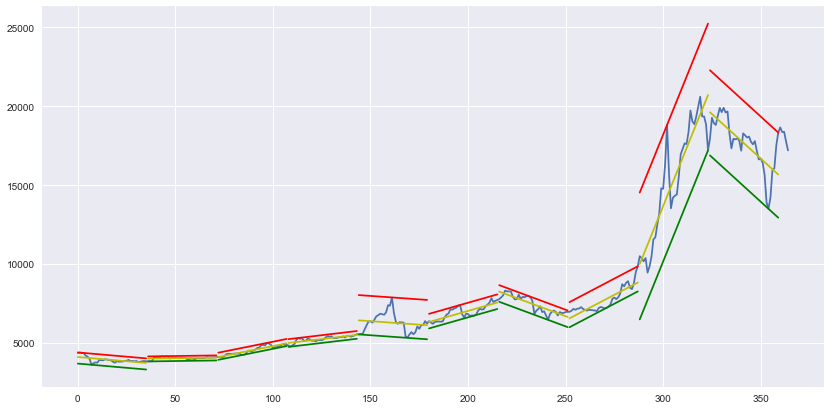

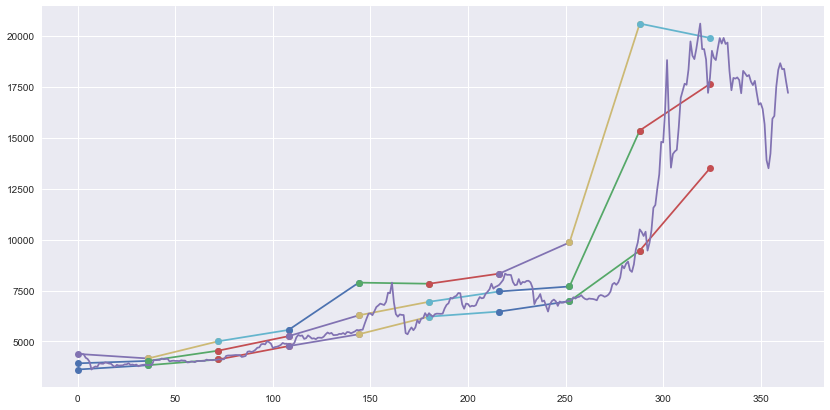

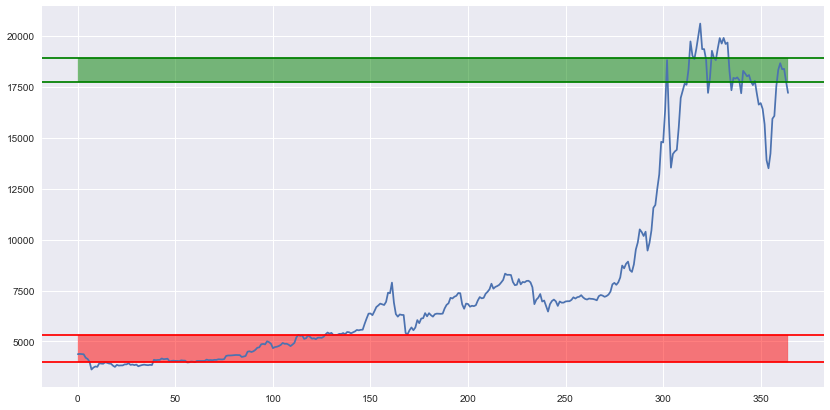

metrics_func rolling_mean=2940.278963120883, metrics_func y_fit=1674.1519187819645


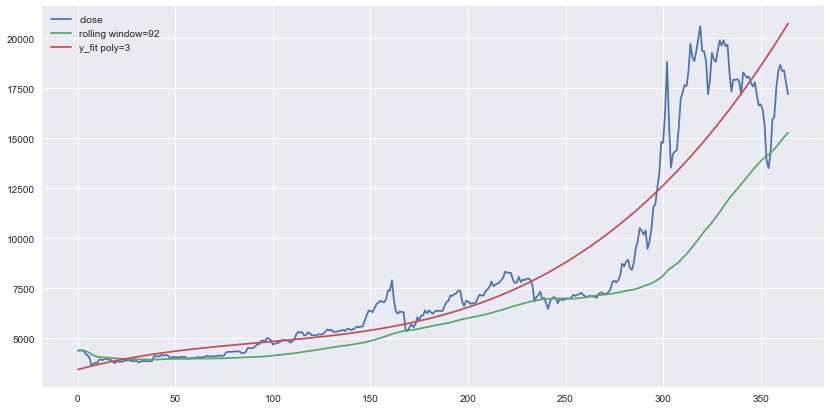

best poly = 3, zoom=False


In [13]:
def show_tl(tc='btc', show_cnt=365, offset=0, step_x=1.0):
    tc = btc if tc =='btc'else ltc
    show_cnt = int(show_cnt)
    offset = int(offset)
    step_x = float(step_x)
    
    tc_line = tl.AbuTLine(tc[-show_cnt-offset:len(tc) - offset].close, 'tc_line')
    # 可视化技术线拟合曲线及上下拟合通道曲线
    tc_line.show_regress_trend_channel(step_x=step_x)
    # 可视化可视化技术线骨架通道
    tc_line.show_skeleton_channel(step_x=step_x)
    # 可视化技术线比例分割的区域
    tc_line.show_percents()
    # 可视化技术线最优拟合次数
    tc_line.show_best_poly()
show_tl()

上面的show_tl函数如果想要切换观察周期，需要不断改参数，太麻烦，下面使用ipywidgets的可交互插件进行可视化控制：

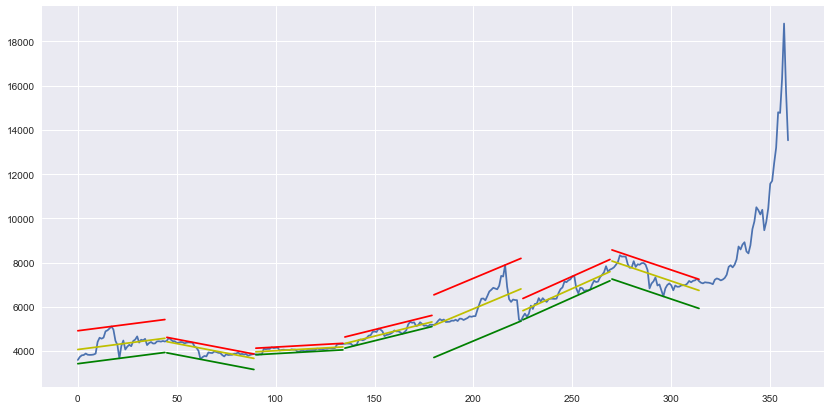

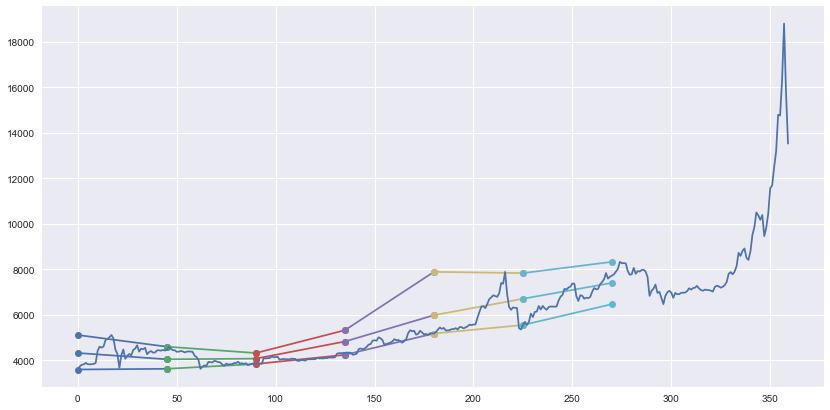

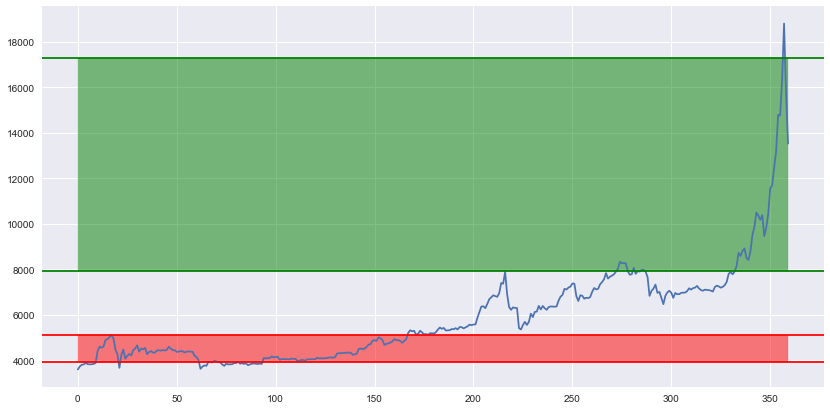

metrics_func rolling_mean=1356.921237307044, metrics_func y_fit=625.2788418035408


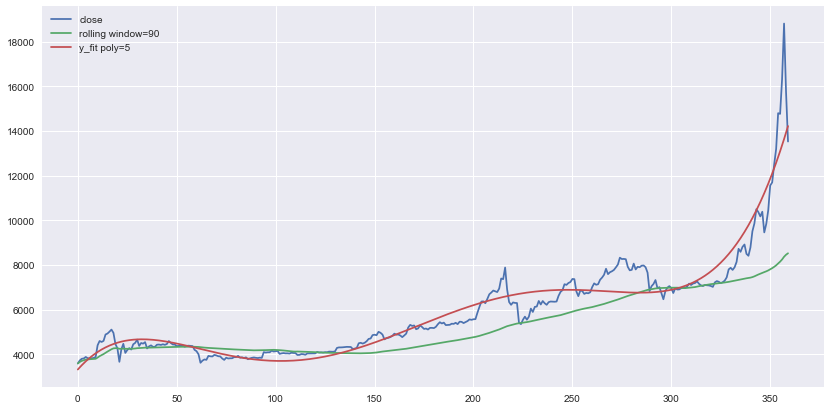

best poly = 5, zoom=False


In [14]:
from ipywidgets import interact

tc_range = ['btc', 'ltc']
show_range = [180, 360, 720, 1080]
offset_range = [0, 60, 120, 180, 250, 360, 720]
step_x_range = [0.8, 1.0, 1.2, 1.5, 1.8, 2.0]
_ = interact(show_tl, tc=tc_range, show_cnt=show_range, offset=offset_range, step_x=step_x_range)

通过上面的数据分析和可视化分析，对比特币使用和之前策略相同的参数和策略组合和参数分配其实是不合适的，因为币类市场的振幅实在是太大，而且走势分布混乱，止盈止损的设定也并不清晰，实际上最适合的量化策略是做一些统计套利策略，关于高频统计套利相关策略，会在之后的章节使用比特币，莱特币做为示例。

下面我们本节先不管回测结果如何，先和之前使用的策略一样的情况下进行回测示例。

### 3. 比特币，莱特币市场的回测

与A股市场，港股类似首先将abupy量化环境设置为E_MARKET_TARGET_TC代表币类市场，代码如下所示：

In [14]:
# 设置市场类型为港股
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_TC

#买入因子，卖出因子等依然使用相同的设置，如下所示：
read_cash = 1000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

继续使用run_loop_back进行回测，之前示例回测都是使用n_folds参数，下面换一种写法示例，使用start， end做为参数:

* start='2013-09-01'
* end='2017-07-26'

choice_symbols=None或者使用['btc', 'ltc']都行, 如果使用None则做全市场测试，但是由于币类市场中暂时只有btc和ltc，所以这里传递['btc', 'ltc']和传递None的结果是一致的。

下面通过：
    
    abupy.beta.atr.g_atr_pos_base = 0.5
    
调整了默认仓位管理的控制参数，仓位管理类默认使用的是AbuAtrPosition, 调整abupy.beta.atr.g_atr_pos_base=0.5的作用可理解为将每一笔交易的买入资金基数设置为初始资金数50%，g_atr_pos_base默认值为0.1，即10%的资金量做为买入基数。

之所以需要调整资金管理的仓位基数是因为回测中的股票池只有两支btc, ltc，为了提高资金利用率，所以需要调整g_atr_pos_base值。

备注：实际上不必特别在意abupy.beta.atr.g_atr_pos_base仓位，根据回测结果中的策略资金利用率比例不断调整就行，而且策略资金利用率比例不仅和回测中使用的股票池的数量有关，和回测中使用的买入策略数量也相关，比如下面的回测虽然把每次买入时的仓位调整的很高了，但是策略资金利用率比例依然不高的原因即是因为使用的买入策略只有两个，如果有多个策略且策略生效频率很高，即使股票池只有一支股票，策略资金利用率也可以很高。

关于仓位管理的更多详情请阅读AbuPositionBase，AbuAtrPosition或者《量化交易之路》中的相关内容

In [ ]:
# 注意这里把atr资金管理的仓位基数设置为0.5，即50%
abupy.beta.atr.g_atr_pos_base = 0.5
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2013-09-01',
                                                   end='2017-07-26',
                                                   choice_symbols=None)
ABuProgress.clear_output()

买入后卖出的交易数量:43
胜率:51.1628%
平均获利期望:35.8877%
平均亏损期望:-10.0494%
盈亏比:4.8866
策略收益: 392.9862%
基准收益: 2036.0891%
策略年化收益: 69.4965%
基准年化收益: 360.0663%
策略买入成交比例:69.7674%
策略资金利用率比例:14.4106%
策略共执行1425个交易日


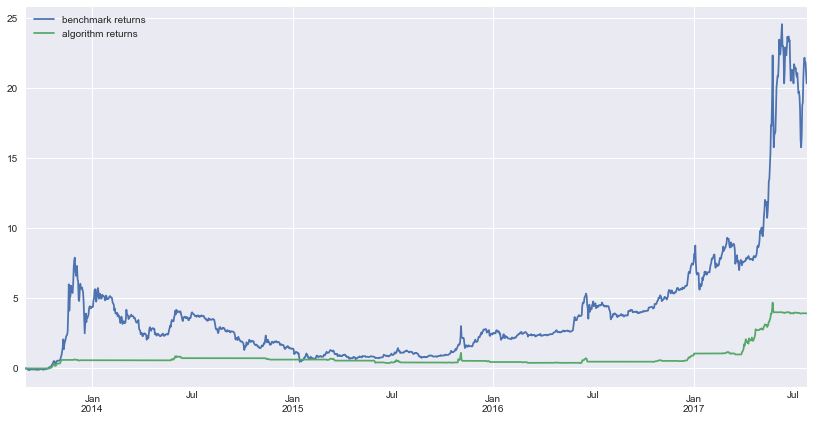

In [16]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

从收益曲线对比上发现完全输给了基准的收益，虽然策略收益也有: 392%，但是既然做了高风险的产品，没有高的收益是不对的，不要认为这是贪心，俗话说操着卖白粉的心, 赚着卖白菜的钱，就是这种情况。

备注：币类市场使用的基准大盘就是比特币

要想改善突破策略收益最简单的方式就是如下方式：

In [ ]:
# 卖出因子只使用AbuFactorAtrNStop，且止盈止损参数都设置100
sell_factors = [
    {'stop_loss_n': 100, 'stop_win_n': 100,
     'class': AbuFactorAtrNStop},
    ]
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2013-09-01',
                                                   end='2017-07-26',
                                                   choice_symbols=None)
ABuProgress.clear_output()

买入后卖出的交易数量:0
胜率:0.0000%
平均获利期望:0.0000%
平均亏损期望:0.0000%
盈亏比:0.0000
策略收益: 1468.0266%
基准收益: 2036.0891%
策略年化收益: 259.6089%
基准年化收益: 360.0663%
策略买入成交比例:4.6512%
策略资金利用率比例:94.8652%
策略共执行1425个交易日


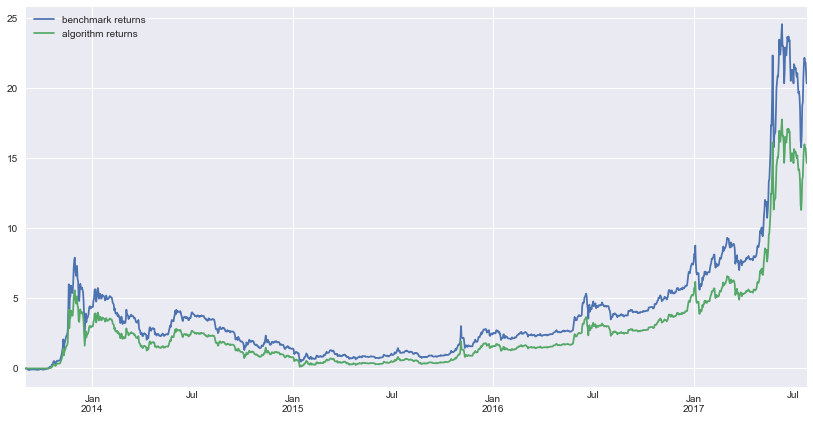

In [21]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

哈，如上所示，其实这就是自己骗自己，卖出因子只使用AbuFactorAtrNStop，且止盈止损参数都设置100即就是买入后就不卖出了，我倒是相信大多数人亏损的时候可以做到不卖出，将亏损的部分坚持持有，对外声称自己是价值投资者、基本面分析者，认为应该长期持有、长线投资，但稍微有了一点利润后就肯定要着急兑现，盈利了那么多之后还能一支持有的其实很了不起。

交易中应该追求的是让利润尽情的奔跑,让亏损尽快的止损，但大多数人做的都是让亏损尽情地亏损，让利润尽快地兑现。

下面使用正经的方法做策略参数选择，首先买入因子沿用之前的60，42天突破就是很大的问题，币类市场的趋势周期从上面的数据分析看明显要小于这两个值，那么到底选择什么值合适呢，这里可以使用abu量化文档‘第七节 寻找策略最优参数和评分’来进行参数选择，下面单只从突破周期介绍使用另一种方法。

使用abupy中的ABuKLUtil.resample_close_mean函数，首先针对之前章节做回测的tsla进行数据进行resample_close_mean

In [22]:
ABuKLUtil.resample_close_mean(ABuSymbolPd.make_kl_df('usTSLA'))

,resample
5D,0.0340
10D,0.0468
21D,0.0683
42D,0.0805
60D,0.1002
90D,0.0931
120D,0.0939


关于ABuKLUtil.resample_close_mean的作用这里不过多讲解，有兴趣自行阅读源代码，这里实际上只需要知道一点，使用周期突破的策略选择的周期应该是ABuKLUtil.resample_close_mean返回值在0.08左右范围的重采样周期。

观察上面resample_close_mean针对tsla数据的结果60D, 42D都是在0.08左右，所以之前一直使用的突破策略选择60日突破和42日突破都是适合tsla做为策略使用的。（实际从上面可以看出21d，42d，60d，90d，120d其实都可以适应tsla，且基本适应大多数股票交易品种）

下面使用resample_close_mean针对比特币，莱特币数据：

In [23]:
ABuKLUtil.resample_close_mean({'btc': btc, 'btc365': btc365, 'ltc': ltc, 'ltc365': ltc365})

,btcresample,btc365resample,ltcresample,ltc365resample
5D,0.0546,0.0491,0.0639,0.0728
10D,0.0847,0.0760,0.0958,0.1147
21D,0.1490,0.1447,0.1603,0.2230
42D,0.2610,0.2383,0.3045,0.5397
60D,0.3676,0.3278,0.4135,0.7749
90D,0.4067,0.4875,0.5997,1.5244
120D,0.3779,0.6344,0.7314,2.1204


从输出可以看出10d以上就已经不适合比特币和莱特币做为周期参数了：

    10D	0.0847	0.0760	0.0958	0.1147
    
下面的回测使用10d和12d，且修改止盈参数stop_win_n从3.0至7.0：

备注：止盈参数的设置本来就要随着做的品种的风险而定，风险越大的，止盈也必要要提高，否则不管怎么优化其它策略，参数收益都不会高，7.0也只是我随意写的数，读者可尝试使用其它值测试

In [25]:
# xd: 10, xd: 12
buy_factors = [{'xd': 10, 'class': AbuFactorBuyBreak},
               {'xd': 12, 'class': AbuFactorBuyBreak}]

# stop_win_n：3.0->7.0
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 7.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

In [26]:
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2013-09-01',
                                                   end='2017-07-26',
                                                   choice_symbols=None)
ABuProgress.clear_output()

买入后卖出的交易数量:229
胜率:51.0917%
平均获利期望:46.7237%
平均亏损期望:-9.3463%
盈亏比:6.8304
策略收益: 2138.7616%
基准收益: 2036.0891%
策略年化收益: 378.2231%
基准年化收益: 360.0663%
策略买入成交比例:70.6897%
策略资金利用率比例:38.3857%
策略共执行1425个交易日


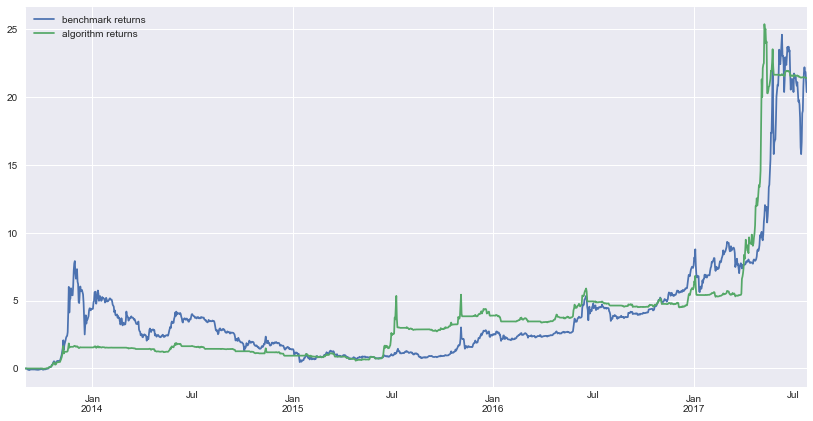

In [27]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

上面的回测结果已经可以比肩基准收益，且读者可以发现这个的收益比上面那个一直持有不卖出的：
    
    'stop_loss_n': 100, 'stop_win_n': 100
    
收益还要好很多，而且更重要的是，采取了多种规避风险策略，止损参数依然使用1.0：

    'stop_loss_n': 1.0, 'stop_win_n': 7.0,
依然使用风险控制止损策略AbuFactorPreAtrNStop，且参数依然使用1.5

    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5}
依然使用风险控制止损策略AbuFactorPreAtrNStop，且参数依然使用1.5

依然使用利润保护止盈策略AbuFactorCloseAtrNStop，且参数依然使用1.5

    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
    
另一点关于比特币，莱特币市场还有一点特殊即是买入数量非整数，精确到小数点后三位，最少交易数量为0.01个币，如下显示交易单的buy_cnt所示：

In [28]:
abu_result_tuple.orders_pd.buy_cnt

2013-09-29    968.117
2013-09-29    968.117
2013-10-10    937.465
2013-10-12    934.364
2013-10-21    596.213
2013-10-30    275.019
2013-11-03    372.791
2013-11-15    104.432
2013-11-15    104.432
2013-11-28     33.106
               ...   
2017-06-07     16.361
2017-06-07    964.902
2017-06-17    908.975
2017-06-20    718.460
2017-06-22     20.591
2017-06-24     23.401
2017-07-04    721.415
2017-07-05    726.382
2017-07-21     18.441
2017-07-22     18.385
Name: buy_cnt, dtype: float64

之后的章节会讲解示例为比特币，莱特币专门定制的买入，卖出策略，请关注公众号的更新提醒。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)
abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/ipython/附录C-量化统计分析及指标应用.ipynb)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://union-click.jd.com/jdc?d=ddV9Uw)

更多关于量化交易相关请稍后阅读《量化交易之路》暂未出版

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)